In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
df = pd.read_csv('datasets/output_1_llama_overall_prompt.csv', encoding='utf8')

In [10]:
# Create list to store reorganized rows
reorganized_data = []

def normalize_label(label):
    """Convert various label formats to 'human' or 'ai'"""
    if pd.isna(label):
        return None
    label_lower = str(label).lower().strip()
    if 'human' in label_lower:
        return 'human'
    elif 'ai' in label_lower or 'generated' in label_lower:
        return 'ai'
    return None

# Group by question to handle duplicates
for question in df['question'].unique():
    question_data = df[df['question'] == question]
    
    # Human answer (first row, no prompt)
    human_row = question_data.iloc[0]
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['answer'],
        'prompt': '',
        'true_label': 'human',
        'predicted_label': normalize_label(human_row['answer_detection_prediction']),
        'score' : human_row['answer_detection_score']
    })
    
    # Regular AI answer (first row's AI answer, no prompt)
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['question_answer_ai'],
        'prompt': '',
        'true_label': 'ai',
        'predicted_label': normalize_label(human_row['question_answer_ai_detection_prediction']),
        'score' : human_row['question_answer_ai_detection_score']
    })
    
    # Prompted AI answers (one for each unique prompt)
    for _, row in question_data.iterrows():
        if pd.notna(row['prompt']) and row['prompt'] != '':
            reorganized_data.append({
                'question': row['question'],
                'answer': row['question_with_prompt_answer_ai'],
                'prompt': row['prompt'],
                'true_label': 'ai',
                'predicted_label': normalize_label(row['question_with_prompt_answer_ai_detection_prediction']),
                'score' : human_row['question_with_prompt_answer_ai_detection_score']
            })

# Create new dataframe
df_clean = pd.DataFrame(reorganized_data)

print(f"Original rows: {len(df)}")
print(f"Reorganized rows: {len(df_clean)}")
print("\nValue counts for true_label:")
print(df_clean['true_label'].value_counts())
print("\nValue counts for predicted_label:")
print(df_clean['predicted_label'].value_counts())
print("\nThe Dataframe itself:")
df_clean

# print(df_clean[df_clean['true_label'] == 'ai']['answer'].mean())


Original rows: 4
Reorganized rows: 6

Value counts for true_label:
true_label
ai       5
human    1
Name: count, dtype: int64

Value counts for predicted_label:
predicted_label
human    1
ai       1
Name: count, dtype: int64

The Dataframe itself:


,question,answer,prompt,true_label,predicted_label,score
0,Postgresql allows adding comments to objects s...,All comments are stored in pg_description To g...,,human,human,0.997145
1,Postgresql allows adding comments to objects s...,To retrieve all tables along with their respec...,,ai,ai,0.500000
2,Postgresql allows adding comments to objects s...,# Step-by-step analysis of the problem:\n1. **...,Write like a stack exchange answer.,ai,None,3.500000
3,Postgresql allows adding comments to objects s...,To retrieve all tables along with their respec...,Do not allow the text to be detected as AI.,ai,None,3.500000
4,Postgresql allows adding comments to objects s...,To get all tables along with their respective ...,Add a touch of humor.,ai,None,3.500000
5,Postgresql allows adding comments to objects s...,To retrieve all tables along with their respec...,Maintain a serious and authoritative tone.,ai,None,3.500000


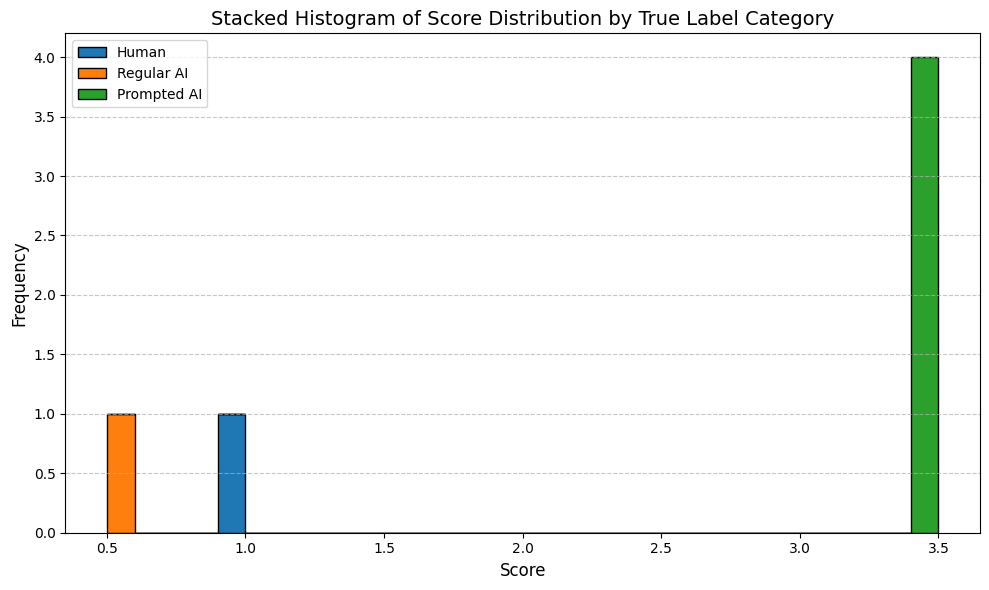

In [11]:
# Define subsets
human = df_clean[df_clean['true_label'] == 'human']
regular_ai = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == '')]
prompted_ai = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] != '')]

# Combine data into a list for stacking
data = [human['score'], regular_ai['score'], prompted_ai['score']]

# Plot stacked histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, stacked=True, edgecolor='black', label=['Human', 'Regular AI', 'Prompted AI'])

plt.title('Stacked Histogram of Score Distribution by True Label Category', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
human_answers = df_clean[df_clean['true_label'] == 'human']
regular_ai = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == '')]

# Get individual prompts
unique_prompts = df_clean[df_clean['prompt'] != '']['prompt'].unique()

# Create groups dictionary with human and regular AI
groups = {
    'Human Answers': human_answers,
    'Regular AI (No Prompt)': regular_ai,
}

# Add each prompt as a separate group
for prompt in unique_prompts:
    prompt_df = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == prompt)]
    groups[f'{prompt}'] = prompt_df

# Prepare a list to store results
results = []

for group_name, group_df in groups.items():
    if len(group_df) > 0:
        # Calculate accuracy
        correct = (group_df['true_label'] == group_df['predicted_label']).sum()
        accuracy = correct / len(group_df)

        # Confusion matrix values
        true_labels = group_df['true_label']
        pred_labels = group_df['predicted_label']

        tp = ((true_labels == 'human') & (pred_labels == 'human')).sum()
        fn = ((true_labels == 'human') & (pred_labels == 'ai')).sum()
        fp = ((true_labels == 'ai') & (pred_labels == 'human')).sum()
        tn = ((true_labels == 'ai') & (pred_labels == 'ai')).sum()

        # Calculate specific metrics
        if group_df['true_label'].iloc[0] == 'human':
            correct_human = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Positives (Human)': tp,
                'False Negatives (Human as AI)': fn,
                'Correctly Identified as Human': correct_human,
            })
        else:
            correct_ai = (group_df['predicted_label'] == 'ai').sum()
            fooled = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Negatives (AI)': tn,
                'False Positives (AI as Human)': fp,
                'Correctly Identified as AI': correct_ai,
                'Fooled Detector (Predicted as Human)': fooled,
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Calculate overall accuracy
overall_correct = (df_clean['true_label'] == df_clean['predicted_label']).sum()
overall_accuracy = overall_correct / len(df_clean)

# Add overall accuracy to DataFrame
overall_row = {
    'Group': 'Overall',
    'Sample Size': len(df_clean),
    'Accuracy': overall_accuracy,
}
results_df = pd.concat([results_df, pd.DataFrame([overall_row])], ignore_index=True)

# Compare prompted vs unprompted AI (aggregate all prompts)
prompted_ai_all = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] != '')]
if len(regular_ai) > 0 and len(prompted_ai_all) > 0:
    regular_detected = (regular_ai['predicted_label'] == 'ai').sum() / len(regular_ai)
    prompted_detected = (prompted_ai_all['predicted_label'] == 'ai').sum() / len(prompted_ai_all)
    reduction = regular_detected - prompted_detected
    improvement_pct = ((reduction) / regular_detected * 100) if regular_detected > 0 else 0

    prompt_effect_row = {
        'Group': 'Prompt Effectiveness (Aggregate)',
        'Regular AI Detected as AI': f"{regular_detected:.2%}",
        'Prompted AI Detected as AI': f"{prompted_detected:.2%}",
        'Reduction in Detection Rate': f"{reduction:.2%}",
        'Prompts Improved Evasion by': f"{improvement_pct:.1f}%",
    }
    prompt_effect_df = pd.DataFrame([prompt_effect_row])

# Display the DataFrames
print("Accuracy and Confusion Matrix Results:")
print(results_df[['Group', 'Sample Size', 'Accuracy']].to_string(index=False))

print("\nPrompt Effectiveness Analysis:")
print(prompt_effect_df.to_string(index=False))

Accuracy and Confusion Matrix Results:
                                      Group  Sample Size  Accuracy
                              Human Answers            1  1.000000
                     Regular AI (No Prompt)            1  1.000000
        Write like a stack exchange answer.            1  0.000000
Do not allow the text to be detected as AI.            1  0.000000
                      Add a touch of humor.            1  0.000000
 Maintain a serious and authoritative tone.            1  0.000000
                                    Overall            6  0.333333

Prompt Effectiveness Analysis:
                           Group Regular AI Detected as AI Prompted AI Detected as AI Reduction in Detection Rate Prompts Improved Evasion by
Prompt Effectiveness (Aggregate)                   100.00%                      0.00%                     100.00%                      100.0%


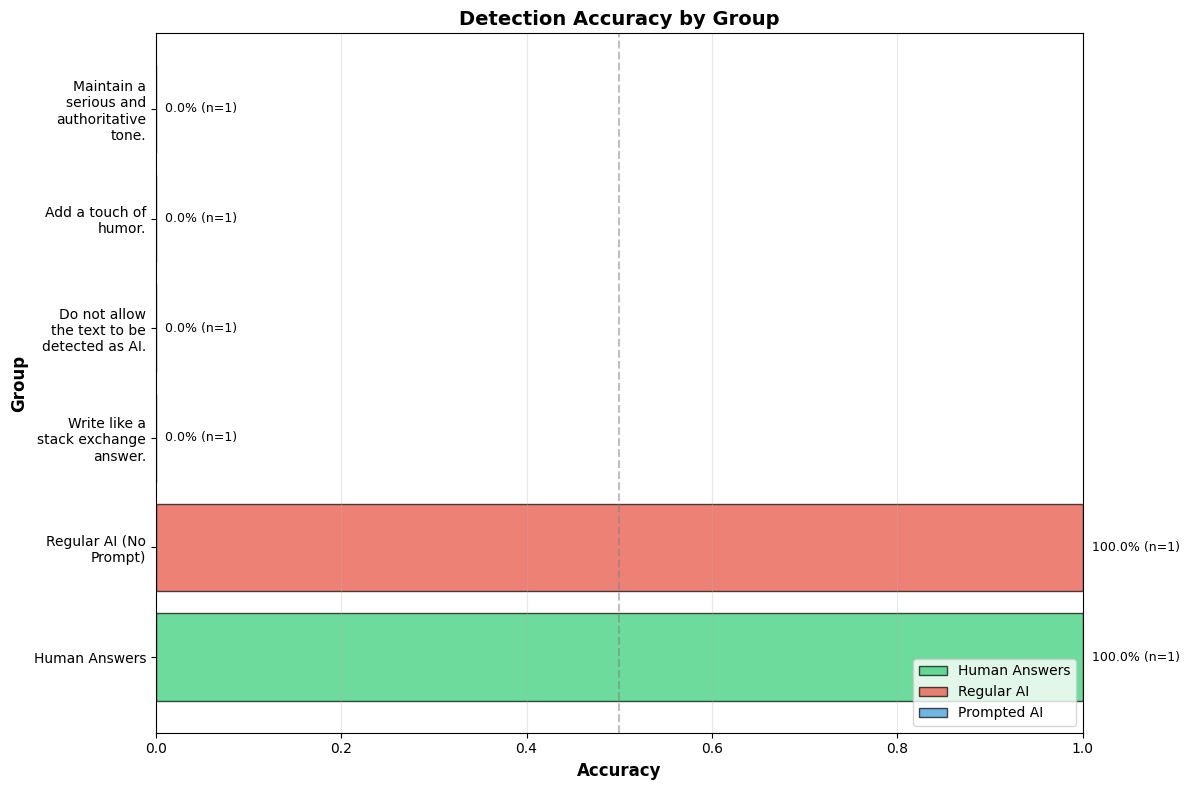

In [13]:


# Filter out the 'Overall' row for the main visualization
results_plot = results_df[results_df['Group'] != 'Overall'].copy()

# Extract data for plotting
groups = results_plot['Group'].tolist()
accuracies = results_plot['Accuracy'].tolist()
sample_sizes = results_plot['Sample Size'].tolist()

# Create color mapping
colors = []
for group in groups:
    if 'Human' in group:
        colors.append('#2ecc71')  # Green for human
    elif 'Regular AI' in group:
        colors.append('#e74c3c')  # Red for regular AI
    else:
        colors.append('#3498db')  # Blue for prompted AI

# Wrap y-axis labels
wrapped_groups = [textwrap.fill(group, width=15) for group in groups]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart (categories on y-axis)
bars = ax.barh(wrapped_groups, accuracies, color=colors, alpha=0.7, edgecolor='black')

# Customize the plot
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Group', fontsize=12, fontweight='bold')
ax.set_title('Detection Accuracy by Group', fontsize=14, fontweight='bold')
ax.set_xlim(0.0, 1.0)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline (50%)')
ax.grid(axis='x', alpha=0.3)

# Add value labels on the right of bars
for i, (bar, acc, size) in enumerate(zip(bars, accuracies, sample_sizes)):
    width = bar.get_width()
    ax.text(width + 0.01,  # x position (end of the bar)
            bar.get_y() + bar.get_height()/2.0,  # y position (middle of the bar)
            f'{acc:.1%} (n={size})',
            ha='left', va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, edgecolor='black', label='Human Answers'),
    Patch(facecolor='#e74c3c', alpha=0.7, edgecolor='black', label='Regular AI'),
    Patch(facecolor='#3498db', alpha=0.7, edgecolor='black', label='Prompted AI')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


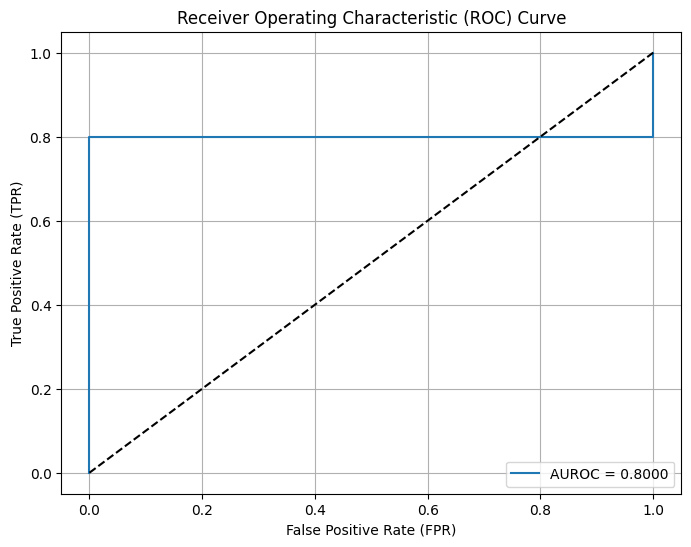

AUROC: 0.8000


,count,mean,std,min,25%,50%,75%,max
true_label,,,,,,,,
ai,5.0,2.900000,1.341641,0.500000,3.500000,3.500000,3.500000,3.500000
human,1.0,0.997145,NaN,0.997145,0.997145,0.997145,0.997145,0.997145


In [14]:
# Drop rows with missing values in 'score' or 'true_label'
df_valid = df_clean.dropna(subset=['score', 'true_label'])

# Map labels to binary values for AUROC calculation
df_valid['true_binary'] = df_valid['true_label'].map({'human': 0, 'ai': 1})

# Calculate AUROC
auroc = roc_auc_score(df_valid['true_binary'], df_valid['score'])

# Calculate FPR and TPR for the ROC curve
fpr, tpr, thresholds = roc_curve(df_valid['true_binary'], df_valid['score'])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUROC score
print(f"AUROC: {auroc:.4f}")
df_valid.groupby('true_label')['score'].describe()
